In [67]:
%matplotlib inline

# DATA ANALYSIS
import pandas as pd
import numpy as np
import pickle
import re
import math
import datetime

# DATA RECOVERY
import geopy
from geopy.geocoders import Nominatim 

# DATA VISUALIZATION
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins


# CHICAGO HEALTH FOOD INSPECTION CLEANING

RAW DATAFRAME

In [68]:
fi_df = pd.read_csv('./Data/food-inspections.csv', sep = ',', header = 0, names = ['inspection id', 'restaurant name DBA', 'restaurant name AKA', 'license number','facility type','risk','address','city','state','zip','inspection date','inspection type','result','violations','latitude','longitude','location','historical','zip codes','commun. areas','census tr.','wards'])

In [69]:
fi_df.head()

,inspection id,restaurant name DBA,restaurant name AKA,license number,facility type,risk,address,city,state,zip,...,result,violations,latitude,longitude,location,historical,zip codes,commun. areas,census tr.,wards
0,2345969,LORDANCHILD CHRISTIAN DAY CARE INC.,LORDANCHILD CHRISTIAN DAY CARE INC.,2215931.0,Children's Services Facility,Risk 1 (High),3344 W 79TH ST,CHICAGO,IL,60652.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.749915,-87.706628,"{'longitude': '41.749914910076974', 'latitude'...",NaN,NaN,NaN,NaN,NaN
1,2345986,TACOS & SALSAS LLC,TACOS & SALSAS,2684121.0,Mobile Food Preparer,Risk 2 (Medium),2300 S THROOP ST,CHICAGO,IL,60608.0,...,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.850451,-87.658798,"{'longitude': '41.85045102427', 'latitude': '-...",NaN,NaN,NaN,NaN,NaN
2,2345977,"KIMBALL DAY CARE CENTER & KINDERGARTEN , INC.","KIMBALL DAY CARE CENTER & KINDERGARTEN , INC.",2215859.0,Daycare (2 - 6 Years),Risk 1 (High),1636 N KIMBALL AVE,CHICAGO,IL,60647.0,...,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.911155,-87.711859,"{'longitude': '41.911154536126396', 'latitude'...",NaN,NaN,NaN,NaN,NaN
3,2345959,DUNKIN DONUTS,DUNKIN DONUTS,1803815.0,Restaurant,Risk 2 (Medium),4453 S ARCHER AVE,CHICAGO,IL,60632.0,...,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.812307,-87.706919,"{'longitude': '41.81230749019629', 'latitude':...",NaN,NaN,NaN,NaN,NaN
4,2345967,SHEEBA MEAT & GROCERY,SHEEBA MEAT & GROCERY,2699426.0,Grocery Store,Risk 2 (Medium),4307 W LAWRENCE AVE,CHICAGO,IL,60630.0,...,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968045,-87.735750,"{'longitude': '41.96804517534159', 'latitude':...",NaN,NaN,NaN,NaN,NaN


In [70]:
fi_df.dtypes

inspection id            int64
restaurant name DBA     object
restaurant name AKA     object
license number         float64
facility type           object
risk                    object
address                 object
city                    object
state                   object
zip                    float64
inspection date         object
inspection type         object
result                  object
violations              object
latitude               float64
longitude              float64
location                object
historical             float64
zip codes              float64
commun. areas          float64
census tr.             float64
wards                  float64
dtype: object

Based on the description of the dataset provided  [here](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) by the city of Chicago  

__DBA__: legal name of the establishment.  
__AKA__: the name people associates to the establishment.  
__License number__: unique number assigned to the establishment for the purposes of licensing by the Department of Business Affairs and Consumer Protection. An establishment can have more than one license.  
__Type of facility__: Each establishment is described by one of the following: bakery, banquet hall, candy store, caterer, coffee shop, day care center (for ages less than 2), day care center (for ages 2 – 6), day care center (combo, for ages less than 2 and 2 – 6 combined), gas station, Golden Diner, grocery store, hospital, long term care center(nursing home), liquor store, mobile food dispenser, restaurant, paleteria, school, shelter, tavern, social club, wholesaler, or Wrigley Field Rooftop.  
__Risk category of facility__: Each establishment is categorized as to its risk of adversely affecting the public’s health, with 1 being the highest and 3 the lowest. The frequency of inspection is tied to this risk:
 - *risk 1*: two inspections per year.
 - *risk 2*: one inspection per year.
 - *risk 3*: an inspection every two years.
 
__Inspection date__: This is the date the inspection occurred. A particular establishment is likely to have multiple inspections which are denoted by different inspection dates.  
__Inspection type__: An inspection can be one of the following types:
 - *canvass*: the most common type of inspection performed at a frequency relative to the risk of the establishment.
 - *consultation*: when the inspection is done at the request of the owner prior to the opening of the establishment. 
 - *complaint*: when the inspection is done in response to a complaint against the establishment.
 - *license*: when the inspection is done as a requirement for the establishment to receive its license to operate.
 - *suspect food poisoning* when the inspection is done in response to one or more persons claiming to have gotten ill as a result of eating at the establishment (a specific type of complaintbased inspection).
 - *task-force inspection* when an inspection of a bar or tavern is done.
Re-inspections can occur for most types of these inspections and are indicated as such.    

__Results__: An inspection can pass, pass with conditions or fail. Establishments receiving a ‘pass’ were found to have no critical or serious violations (violation number 1-14 and 15- 29, respectively). Establishments receiving a ‘pass with conditions’ were found to have critical or serious violations, but these were corrected during the inspection. Establishments receiving a ‘fail’ were found to have critical or serious violations that were not correctable during the inspection. An establishment receiving a ‘fail’ does not necessarily mean the establishment’s licensed is suspended. Establishments found to be out of business or not located are indicated as such.
__Violations__: An establishment can receive one or more of 45 distinct violations (violation numbers 1-44 and 70). For each violation number listed for a given establishment, the requirement the establishment must meet in order for it to NOT receive a violation is noted, followed by a specific description of the findings that caused the violation to be issued.

## 1.1 CLEANING, UNDERSTANDING THE DATASET

### 1.1.1 Empty columns

First, we need to check which columns are usable, a preview on the file hints that some columns might be completely empty as it is the case for the following:

In [71]:
missg_val = fi_df.isnull().sum().sort_values(ascending = False)
missg_val = missg_val[missg_val > 0] / fi_df.shape[0]
empty_columns = missg_val[missg_val == 1.0]
empty_columns.index

Index(['wards', 'commun. areas', 'zip codes', 'historical', 'census tr.'], dtype='object')

We can clearly observe that some columns are full of null values. So we can remove those columns as a first step for cleaning the dataset.

In [72]:
fi_df=fi_df.drop(columns=empty_columns.index)
fi_df.head(1)

,inspection id,restaurant name DBA,restaurant name AKA,license number,facility type,risk,address,city,state,zip,inspection date,inspection type,result,violations,latitude,longitude,location
0,2345969,LORDANCHILD CHRISTIAN DAY CARE INC.,LORDANCHILD CHRISTIAN DAY CARE INC.,2215931.0,Children's Services Facility,Risk 1 (High),3344 W 79TH ST,CHICAGO,IL,60652.0,2019-11-20T00:00:00.000,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.749915,-87.706628,"{'longitude': '41.749914910076974', 'latitude'..."


### 1.1.2 Removing NaN/Null values  

Let's observe the columns that still have nan values

In [73]:
def plot_nan(without_violations = True):
    missg_val = fi_df.isnull().sum().sort_values(ascending = False)
    if(without_violations):
        missg_val = missg_val[missg_val > 0].iloc[1:]
    else:
        missg_val = missg_val[missg_val > 0]
    return sns.barplot(x = missg_val, y = missg_val.index)

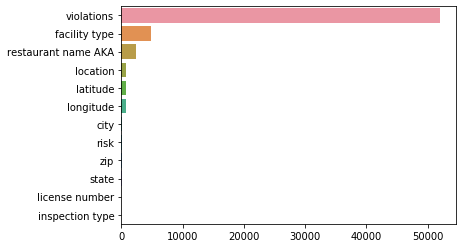

In [74]:
plot_nan(without_violations = False)

#### 1.1.2.1 VIOLATIONS

We won't be able to replace the missing values. Indeed those informations comes from the inspections so we can't recover them or create them. However, all restaurants won't necessary cause violations. Indeed, we have to consider that a restaurant that passed the last sanitar control may have succeded because of this. So here it doesn't have to be considered as a missing value. However if the violations aren't reported while the control has not been successfully passed, we would consider that the information is not correctly reported and then delete the corresponding line. 

In [75]:
fi_df = fi_df[((~fi_df['violations'].isna()) & fi_df['violations'].apply(lambda x : x != '')) | fi_df['result'].apply(lambda x : x == 'Pass')]

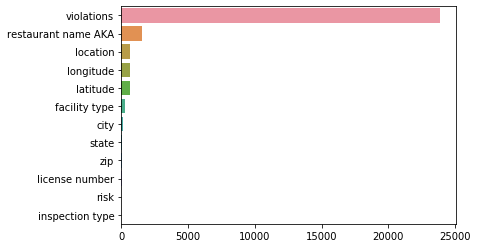

In [76]:
plot_nan(without_violations = False)

we can see that we almost delete half of the rows that have null values in the violotions column. But we have 20000 rows so more than 10% of the dataframe that passed the control with no violation reported. This shows that it is important not to delete them.

#### 1.1.2.2 RESTAURANT NAME AKA

In [77]:
fi_df[['restaurant name DBA','restaurant name AKA']].head()

,restaurant name DBA,restaurant name AKA
0,LORDANCHILD CHRISTIAN DAY CARE INC.,LORDANCHILD CHRISTIAN DAY CARE INC.
1,TACOS & SALSAS LLC,TACOS & SALSAS
2,"KIMBALL DAY CARE CENTER & KINDERGARTEN , INC.","KIMBALL DAY CARE CENTER & KINDERGARTEN , INC."
3,DUNKIN DONUTS,DUNKIN DONUTS
4,SHEEBA MEAT & GROCERY,SHEEBA MEAT & GROCERY


according to the head of the dataframe, we can see that we can recover the AKA name with the DBA name of the restaurant. So we can try actually to merge these two columns by prefering the AKA name.
As we didn't detect any null DBA name, we should fill every missing value in this column processing this way.

In [78]:
fi_df['restaurant name'] = fi_df.apply(lambda row : row['restaurant name AKA'] if not pd.isnull(row['restaurant name AKA']) else row['restaurant name DBA'], axis = 1)
fi_df.drop(columns = ['restaurant name AKA', 'restaurant name DBA'], inplace = True)
fi_df.head()

,inspection id,license number,facility type,risk,address,city,state,zip,inspection date,inspection type,result,violations,latitude,longitude,location,restaurant name
0,2345969,2215931.0,Children's Services Facility,Risk 1 (High),3344 W 79TH ST,CHICAGO,IL,60652.0,2019-11-20T00:00:00.000,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.749915,-87.706628,"{'longitude': '41.749914910076974', 'latitude'...",LORDANCHILD CHRISTIAN DAY CARE INC.
1,2345986,2684121.0,Mobile Food Preparer,Risk 2 (Medium),2300 S THROOP ST,CHICAGO,IL,60608.0,2019-11-20T00:00:00.000,License Re-Inspection,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.850451,-87.658798,"{'longitude': '41.85045102427', 'latitude': '-...",TACOS & SALSAS
2,2345977,2215859.0,Daycare (2 - 6 Years),Risk 1 (High),1636 N KIMBALL AVE,CHICAGO,IL,60647.0,2019-11-20T00:00:00.000,License,Fail,"1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOW...",41.911155,-87.711859,"{'longitude': '41.911154536126396', 'latitude'...","KIMBALL DAY CARE CENTER & KINDERGARTEN , INC."
3,2345959,1803815.0,Restaurant,Risk 2 (Medium),4453 S ARCHER AVE,CHICAGO,IL,60632.0,2019-11-20T00:00:00.000,Canvass,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.812307,-87.706919,"{'longitude': '41.81230749019629', 'latitude':...",DUNKIN DONUTS
4,2345967,2699426.0,Grocery Store,Risk 2 (Medium),4307 W LAWRENCE AVE,CHICAGO,IL,60630.0,2019-11-20T00:00:00.000,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.968045,-87.735750,"{'longitude': '41.96804517534159', 'latitude':...",SHEEBA MEAT & GROCERY


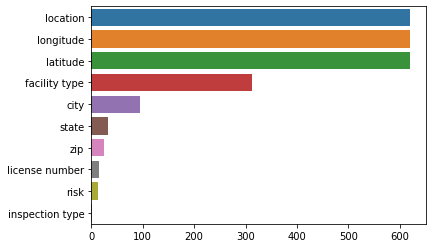

In [79]:
plot_nan()

#### 1.1.2.3 LOCATION / LONGITUDE / LATITUDE

In [80]:
missg_val

wards                  1.000000
commun. areas          1.000000
zip codes              1.000000
historical             1.000000
census tr.             1.000000
violations             0.265280
facility type          0.024338
restaurant name AKA    0.012528
latitude               0.003512
longitude              0.003512
location               0.003512
city                   0.000708
risk                   0.000362
zip                    0.000255
state                  0.000214
license number         0.000087
inspection type        0.000005
dtype: float64

We observe that there is exactly the same number of missing values for location, longitude and latitude. We also know that the location information is just the merge of the two longitude and latitude information. We found a library that would help us to recover the longitude and latitude information based on the address.   

However, it seems that there are errors or unprecisions in the address of the restaurants that have unkown location. As a consequence, the geopy library is not powerfull enough to retrieve the location based on those uncorrect addresses. We show an exemple right bellow

In [81]:
fi_df[fi_df['address'] == '2009 S LAFIN ST ']

,inspection id,license number,facility type,risk,address,city,state,zip,inspection date,inspection type,result,violations,latitude,longitude,location,restaurant name
150,2345633,2578370.0,Restaurant,Risk 2 (Medium),2009 S LAFIN ST,CHICAGO,IL,60608.0,2019-11-14T00:00:00.000,License Re-Inspection,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",NaN,NaN,NaN,VEENO
1526,2315463,2578370.0,Restaurant,Risk 2 (Medium),2009 S LAFIN ST,CHICAGO,IL,60608.0,2019-10-08T00:00:00.000,License,Fail,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",NaN,NaN,NaN,VEENO


In this example we can see that the restaurants with this address have nan location/latitude/longitude. Let's try to find this informations with geopy.

In [82]:
geolocator = Nominatim(user_agent = 'project_ADA')

In [83]:
location = geolocator.geocode('2009 S LAFIN ST ')
print(location)

Lafin Street, Bayside Lakes, Palm Bay, Brevard County, Florida, 32908-1206, United States


It finds a result that is actually located in Palm Bay Florida. If we try to precise the city in the address :

In [84]:
location = geolocator.geocode('2009 S LAFIN ST Chicago')
print(location)

None


It doesn't find any location in Chicago. By looking in Google, we noticed that there is an error in the address. If we correct it we obtain a relevent location.

In [85]:
location = geolocator.geocode('2009 S LAFLIN ST Chicago')
print(location)

2009, South Laflin Street, Lower West Side, Chicago, Cook County, Illinois, 60608, United States of America


However those kind of errors or misunderstandings can be correctly automatically. So we abandoned the idea of recovering the location with geopy and decided to remove the rows with unknown location.

In [86]:
fi_df=fi_df.dropna(subset=['latitude', 'longitude', 'location'], how = "any")

We also wants to directly retrieve float values of both longitude and latitude directly from the 'location' column then it would be more convenient when retrieving those data for maps plotting.

In [87]:
def get_location(string):
    groups = re.findall('-*[0-9]+.[0-9]+', string) #look at patterns matching longitude and lattitude formats in strings
    return [groups[0], groups[1]] #return an array containing (lattitude,longitude) couples
                             
fi_df['location'] = fi_df.location.apply(lambda x: get_location(x))

In [88]:
fi_df.head(1)

,inspection id,license number,facility type,risk,address,city,state,zip,inspection date,inspection type,result,violations,latitude,longitude,location,restaurant name
0,2345969,2215931.0,Children's Services Facility,Risk 1 (High),3344 W 79TH ST,CHICAGO,IL,60652.0,2019-11-20T00:00:00.000,License,Pass w/ Conditions,"3. MANAGEMENT, FOOD EMPLOYEE AND CONDITIONAL E...",41.749915,-87.706628,"[41.749914910076974, -87.7066283407442]",LORDANCHILD CHRISTIAN DAY CARE INC.


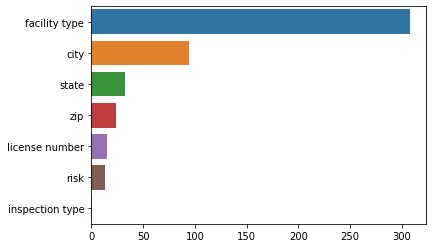

In [89]:
plot_nan()

#### 1.1.2.4 FACILITY TYPE



A lot of kind of facility types exist in the dataset. However not every one of them interests us

In [90]:
fi_df['facility type'] = fi_df['facility type'].str.lower().fillna('unknown')
fi_df['facility type'].value_counts()

restaurant                      113435
grocery store                    21631
school                           11456
children's services facility      2904
bakery                            2504
                                 ...  
(convenience store)                  1
service gas station                  1
incubator                            1
dollar store selling grocery         1
drug store                           1
Name: facility type, Length: 418, dtype: int64

For example, schools doesn't interest us. Furthermore, some words seems to be recurrent such as 'store'. So before removing facility types we don't want, we would regroup them into groups and remove the created categories that are not interested.
The idea is to use a semantic distance between facility type to regroup to ones close to each other. In order to proceed, we retrieve the main facilities, such as 'restaurant' that will absorb the less represented one to create clusters. 

In [91]:
len(fi_df['facility type'].unique())


418

if we take the 10% most represented facilities, we would end up with ~40 categories that seems to be correct.

In [26]:
quantile = fi_df['facility type'].value_counts().quantile([0.9])

In [92]:
vc = fi_df['facility type'].value_counts()
main_categories = vc[vc >= quantile[0.9]].index.to_list()
others = vc[vc < quantile[0.9]].index.to_list()

We make sure we don't have any duplicated facility

In [94]:
set(main_categories).intersection(set(others))

set()

In [95]:
from pyjarowinkler import distance

sc = dict()
for i in others:
    distances = []
    for j in main_categories:
        distances.append(distance.get_jaro_distance(i,j))
    sc[i] = main_categories[np.argmax(distances)]


In [96]:
def get_fc(x):
    if x in main_categories:
        return x
    else:
        return sc[x]

In [97]:
fi_df['facility type'] = fi_df['facility type'].apply(lambda x : get_fc(x))

In [98]:
fi_df['facility type'].value_counts()

restaurant                          113665
grocery store                        21832
school                               11471
children's services facility          3052
bakery                                2566
daycare (2 - 6 years)                 2358
daycare above and under 2 years       2222
long term care                        1341
catering                              1028
liquor                                 739
mobile food dispenser                  688
daycare combo 1586                     644
mobile food preparer                   549
golden diner                           546
wholesale                              512
hospital                               509
unknown                                308
tavern                                 291
daycare (under 2 years)                235
gas station                            226
special event                          223
charter school                         203
shared kitchen user (long term)        199
shelter    

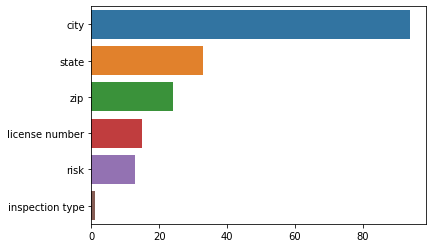

In [99]:
plot_nan()

#### 1.1.2.5 CITY / STATE

In [100]:
fi_df['city'] = np.where(fi_df['city'].isnull(), 'CHICAGO', fi_df['city'])
fi_df['state'] = np.where(fi_df['state'].isnull(), 'IL', fi_df['state'])

#### 1.1.2.6 LICENSE NUMBER

The inspections are done for a given license of an establishment.

In [101]:
fi_df[fi_df['license number'].isnull()]['restaurant name'].unique()

array(['ST. DEMETRIOS CHURCH', "OLD ST. PATRICK'S CHURCH",
       "GOD'S BATTLE AXE PRAYER ACADEMY", 'ST DEMETRIOS CHURCH'],
      dtype=object)

The missing values are for the same religious establishments. They won't interest us for the study so we can drop them.

In [102]:
fi_df.dropna(subset = ['license number'], inplace = True)

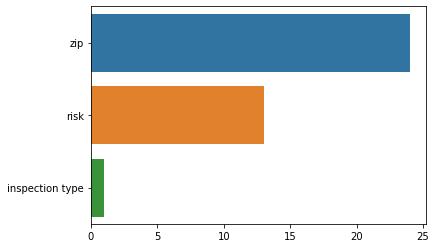

In [103]:
plot_nan()

#### 1.1.2.7 ZIP / INSPECTION TYPE / ZIP

In [104]:
fi_df.dropna(subset = ['zip','inspection type','risk'], inplace = True)

### 1.1.3 Treating columns

#### 1.1.3.1 

In [105]:
fi_df['result'].unique()

array(['Pass w/ Conditions', 'Fail', 'Pass', 'No Entry', 'Not Ready',
       'Out of Business'], dtype=object)

Our research focuses on the city Chicago, our dataset however contains numerous other locations which we have to discard.

In [107]:
fi_df['city'].unique()

array(['CHICAGO', 'Chicago', 'CCHICAGO', 'CHICAGO.', 'CHESTNUT STREET',
       'CHICAGOCHICAGO', 'chicago', 'CHICAGOHICAGO', 'CHicago',
       '312CHICAGO', 'BEDFORD PARK', 'CHCHICAGO', 'SUMMIT', 'LOMBARD',
       'CHICAGOI', 'BLUE ISLAND', 'CHARLES A HAYES', 'CHCICAGO'],
      dtype=object)

It seems that many suburban areas are referenced as the city of the restaurant associated to the inspection. However, some of those suburbs are located too far from Chicago. As a consequence we decided to focus excusively on the location referenced in Chicago.

We notice that there are differents cities refered in the dataframe. Furthermore, we notice that the chicago city is not correctly referenced: "CHICAGOCHICAGO","CHICAGO.", etc.
It also seems that some locations are refered as cities. Those locations could be in Chicago.

Some locations aren't part of Chicago. However we are aware that those locations, such as Oak Lawn or Oak Park, are really close to the city. So the question is, should we have to keep it or not...

In [108]:
def isChicago(x):
    if re.search('.*CHICAGO.*', x):
        return True
    return False

print('the location referenced in chicago represents {0:.3f} % of the dataset'.format(fi_df[fi_df['city'].apply(lambda x: isChicago(str(x)))].shape[0]/fi_df.shape[0]))

the location referenced in chicago represents 0.998 % of the dataset


This ratio shows that removing the other rows referenced in other location won't impact the integrity of the dataset.

In [109]:
temp =  fi_df[fi_df['city'].apply(lambda x: not(isChicago(str(x))))]
temp['city'].unique()

array(['Chicago', 'CHESTNUT STREET', 'chicago', 'CHicago', 'BEDFORD PARK',
       'SUMMIT', 'LOMBARD', 'BLUE ISLAND', 'CHARLES A HAYES', 'CHCICAGO'],
      dtype=object)

In [110]:
zips_chicago = set(temp.zip.unique())

In [111]:
inChicago = fi_df['city'].apply(lambda x : isChicago(str(x))) | fi_df['zip'].apply(lambda x : x in zips_chicago)

In [112]:
fi_df['city'] = np.where(inChicago, 'CHICAGO', 'ELSEWHERE')

In [113]:
fi_df['city'].unique()

array(['CHICAGO'], dtype=object)

Now that we have all restaurants from the city Chicago, we can now drop this column

### Facility types

First we consider the facility types, we are in the skin of a tourist or any other person looking for a place to eat in Chicago. So the facility types such as churches, schools, hospitals etc. are not taken into consideration.

In [114]:
def get_cv(serie):
    tmp = serie.value_counts()
    return tmp.tolist(), tmp.keys().tolist()

In [115]:
facility_count, facility_key = get_cv(fi_df['facility type'])

In [116]:
def merge_minorities(counts, keys, size):
    labels = []
    m_counts = []
    minorities_count = 0
    percent_ref = 0.01 * size
    for c, l in zip(counts, keys):
        if c < percent_ref:
            minorities_count += c
        else:
            labels.append(l)
            m_counts.append(c)
    labels.append('others')
    m_counts.append(minorities_count)
    return m_counts, labels

In [117]:
counts, labels = merge_minorities(facility_count, facility_key, fi_df.shape[0])

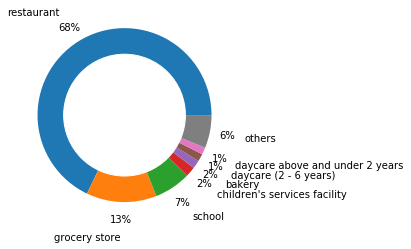

In [118]:
m_circle = plt.Circle((0,0), 0.7, color = "white")
plt.pie(counts, labels = labels, autopct='%1.0f%%', pctdistance=1.2, labeldistance=1.4)
p = plt.gcf()
p.gca().add_artist(m_circle)
plt.show()

We can see that some facilities represented in this dataset is irrelevent for our problematic such as Schools, Children's Services, Daycare... So we want to keep the facilities that target people for buying food at their places. 

In [119]:
#2. drop all values that aren't litterals
fi_df['facility type']=fi_df['facility type'].astype(str)

non_numerical_ft=fi_df['facility type'].apply(lambda f: not f.isdigit())
fi_df=fi_df[non_numerical_ft]

#3. keep only facility types of interest
#discarded_facilities=['care','hospital','church','gas','children','kiosk','store','school','kitchen','facility','wholesale'];
interest=['restaurant','bakery','diner','roof','mobile','bar','diner','breakfast','lounge','grill','tavern', 'store', 'wholesale']
facility_column=fi_df['facility type'].copy().apply(lambda c: c.lower()).apply(lambda c: any( w in c for w in interest))
fi_df=fi_df[facility_column]
fi_df['facility type'] = fi_df['facility type'].apply(lambda c: c.lower())


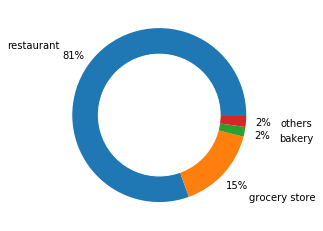

In [120]:
facility_count, facility_key = get_cv(fi_df['facility type'])
counts, labels = merge_minorities(facility_count, facility_key, fi_df.shape[0])
m_circle = plt.Circle((0,0), 0.7, color = "white")
plt.pie(counts, labels = labels, autopct='%1.0f%%', pctdistance=1.2, labeldistance=1.4)
p = plt.gcf()
p.gca().add_artist(m_circle)
plt.show()

Now we have kept facilities that seems to correspond to our problematic.

#### RISK

In [121]:
risk_val = dict()
y = fi_df.risk.unique()
y

array(['Risk 2 (Medium)', 'Risk 1 (High)', 'Risk 3 (Low)'], dtype=object)

In [122]:
risk_val[y[0]] = 1
risk_val[y[1]] = 2
risk_val[y[2]] = 0.5
fi_df['numerical_risk'] = fi_df.risk.apply(lambda x : risk_val[x])

#### inspections id

In [123]:
fi_df['inspection id'].is_unique

False

In [124]:
doublons = fi_df['inspection id'].value_counts()
doublons = doublons[doublons > 1]

In [125]:
fi_df = fi_df[fi_df['inspection id'].apply(lambda x: not(x in doublons))]

#### restaurant name

We remember that the dataset in inspection oriented. Also, the same restaurant can pass many inspections over the years, can fail some of them and pass the others. Also we observed that the same restaurant can have different license numbers.

In [126]:
fi_df[fi_df['restaurant name'] == 'SUBWAY'].groupby('address')['license number'].agg('count').head()

address
1 E 83RD ST            22
100 W 87TH ST          14
100 W RANDOLPH ST      13
1014 S WESTERN AVE     14
1020 W BELMONT AVE     17
Name: license number, dtype: int64

It also shows that a name can be shared by many restaurant. A location can also be shared by different brands. As a consequence, we have to find a way to differenciate each restaurant by its location in a single column. 

In [127]:
#merge restaurant name with address to identify the unique restaurant at a place
fi_df['name'] = fi_df.apply(lambda row : row['restaurant name'] + ' ' + row['address'], axis = 1)

#### license number doublons

In [128]:
doublons = fi_df.groupby('license number').agg({'name':pd.Series.nunique})
doublons = doublons[doublons['name'] > 1.].index.tolist()
fi_df = fi_df[fi_df['license number'].apply(lambda x : not(x in doublons))]

# SAVE CLEAN Dataframe

In [129]:
fi_df.to_pickle('chicago_df.p')